# TITANIC SURVIVANCE MODEL WITH PYTORCH

In [1]:
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
import torch.optim as optim

### **LOAD THE DATA**

In [2]:
# Load the data
df = pd.read_csv('/Users/juannavarro/Desktop/Projects/Titanic/titan/data/train.csv')

In [3]:
# Display the first 5 rows of the data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Display the shape of the data
df.shape

(891, 12)

In [5]:
# Display the percentage of missing values in the data
df.isnull().sum() / df.shape[0] * 100 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [6]:
# Display the columns in the data
df.columns 

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### **DATA ANALYSIS AND PROCESSING**

##### 1. SCALING OF THE SELECTED DATA

In [7]:
# Create a copy to work with the data
df_cleaned = df.copy()

In [8]:
# Delate the innecesary columns
df_cleaned.drop(columns=['PassengerId', 'Name', 'SibSp', 'Fare', 'Ticket', 'Cabin'], inplace=True)

In [9]:
# Check the type of the columns
df_cleaned.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
Parch         int64
Embarked     object
dtype: object

In [10]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical columns
categorical_columns = ['Sex', 'Embarked']

for column in categorical_columns:
    df_cleaned[column] = label_encoder.fit_transform(df_cleaned[column])

df_cleaned.head()

,Survived,Pclass,Sex,Age,Parch,Embarked
0,0,3,1,22.0,0,2
1,1,1,0,38.0,0,0
2,1,3,0,26.0,0,2
3,1,1,0,35.0,0,2
4,0,3,1,35.0,0,2


Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


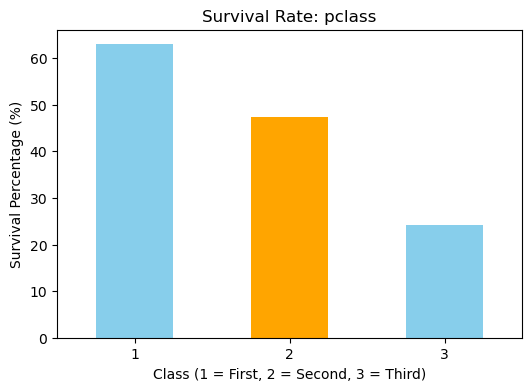

In [11]:
# Calculate the survival rate based on the 'Pclass' column
survival_by_sex = df_cleaned.groupby('Pclass')['Survived'].mean() * 100

# Print the results
print(survival_by_sex)

# Visualize the results in a bar chart
plt.figure(figsize=(6,4))
survival_by_sex.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Survival Rate: pclass')
plt.xlabel('Class (1 = First, 2 = Second, 3 = Third)')
plt.ylabel('Survival Percentage (%)')
plt.xticks(rotation=0)
plt.show()

Given the clear significance of the ‘Pclass’ variable in relation to ‘Survived,’ we will proceed to scale this variable.

In [12]:
# Assign more weight to the better classes (1 > 2 > 3), where class 1 receives the highest weight
df_cleaned['Pclass_Weighted'] = df_cleaned['Pclass'].apply(lambda x: 1.5 if x == 1 else (1.2 if x == 2 else 1))

# Delate 'Pclass' column
df_cleaned.drop(columns=['Pclass'], inplace=True)

Sex
0    74.203822
1    18.890815
Name: Survived, dtype: float64


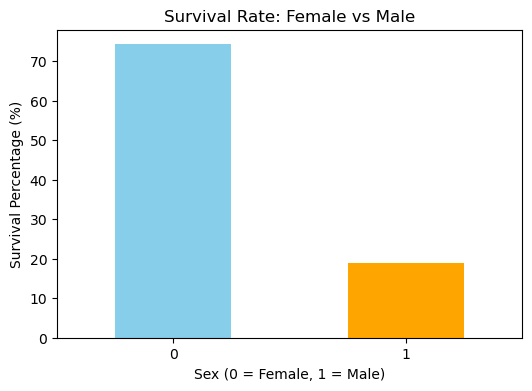

In [13]:
# Calculate the survival rate based on the 'Sex' column
survival_by_sex = df_cleaned.groupby('Sex')['Survived'].mean() * 100

# Print the results
print(survival_by_sex)

# Visualize the results in a bar chart
plt.figure(figsize=(6,4))
survival_by_sex.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Survival Rate: Female vs Male')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Survival Percentage (%)')
plt.xticks(rotation=0)
plt.show()

Given the clear significance of the 'Sex' variable in relation to ‘Survived,’ we will proceed to scale this variable.

In [14]:
# Give more weight to woman
df_cleaned['Sex_Weighted'] = df_cleaned['Sex'].apply(lambda x: 1 if x == 1 else 1.5)

# Delete 'sex' column
df_cleaned.drop(columns=['Sex'], inplace=True)

/var/folders/1y/x8dlnnxn33ddwz4k64_z9vvc0000gn/T/ipykernel_5852/224877000.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age_group = df_cleaned.groupby('Age_Group')['Survived'].mean() * 100


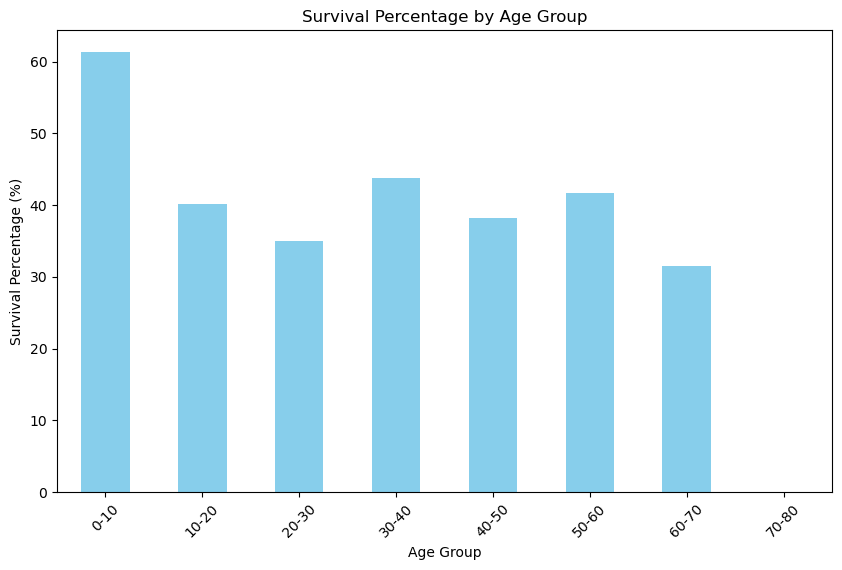

In [15]:
# Group ages into bins/ranges
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df_cleaned['Age_Group'] = pd.cut(df_cleaned['Age'], bins=bins, labels=labels, right=False)

# Calculate the survival percentage for each age group
survival_by_age_group = df_cleaned.groupby('Age_Group')['Survived'].mean() * 100

# Visualize the results
plt.figure(figsize=(10, 6))
survival_by_age_group.plot(kind='bar', color='skyblue')
plt.title('Survival Percentage by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Percentage (%)')
plt.xticks(rotation=45)
plt.show()

Observing the evident relevance of the ‘Age’ variable with respect to ‘survived,’ we will scale this variable as well.

In [16]:
# Scale the 'age' column in relation to survival
df_cleaned['Age_Scaled'] = 1 / (df_cleaned['Age'] + 1)  # +1 to avoid division by 0

# Delete 'age' and 'Age_Group' columns
df_cleaned.drop(columns=['Age', 'Age_Group'], inplace=True)
df_cleaned.head()

,Survived,Parch,Embarked,Pclass_Weighted,Sex_Weighted,Age_Scaled
0,0,0,2,1.0,1.0,0.043478
1,1,0,0,1.5,1.5,0.025641
2,1,0,2,1.0,1.5,0.037037
3,1,0,2,1.5,1.5,0.027778
4,0,0,2,1.0,1.0,0.027778


Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4     0.000000
5    20.000000
6     0.000000
Name: Survived, dtype: float64


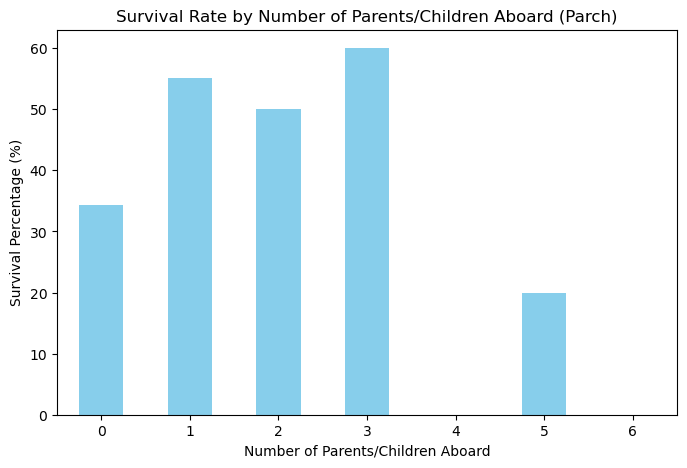

In [17]:
# Calculate the survival rate based on the 'Parch' column
survival_by_parch = df_cleaned.groupby('Parch')['Survived'].mean() * 100

# Print the results
print(survival_by_parch)

# Visualize the results in a bar chart
plt.figure(figsize=(8,5))
survival_by_parch.plot(kind='bar', color='skyblue')
plt.title('Survival Rate by Number of Parents/Children Aboard (Parch)')
plt.xlabel('Number of Parents/Children Aboard')
plt.ylabel('Survival Percentage (%)')
plt.xticks(rotation=0)
plt.show()

We scaled the ‘Parch’ variable by assigning weights based on the survival rate associated with each value, emphasizing higher weights for values correlated with greater survival probabilities.

In [18]:
# Create a dictionary that associates each value of 'Parch' with its survival rate (converted to weight)
parch_weights = {
    0: 1.0,         # Assign weight 1 to the 34.4% rate (base value)
    1: 1.6,         # Assign higher weight to 55.1%
    2: 1.5,         # High weight for 50.0%
    3: 1.7,         # Even higher weight for 60.0%
    4: 0.8,         # Low weight for 0.0%
    5: 0.9,         # Low weight for 20.0%
    6: 0.8          # Low weight for 0.0%
}

# Apply the weights to a new column based on the value of 'Parch'
df_cleaned['Parch_Weighted'] = df_cleaned['Parch'].map(parch_weights)

# Delete the original 'Parch' column
df_cleaned.drop(columns=['Parch'], inplace=True)

# Show the first rows to check
print(df_cleaned[['Parch_Weighted']].head())

   Parch_Weighted
0             1.0
1             1.0
2             1.0
3             1.0
4             1.0


#### 2. CORRELATION AND MISSING VALUES

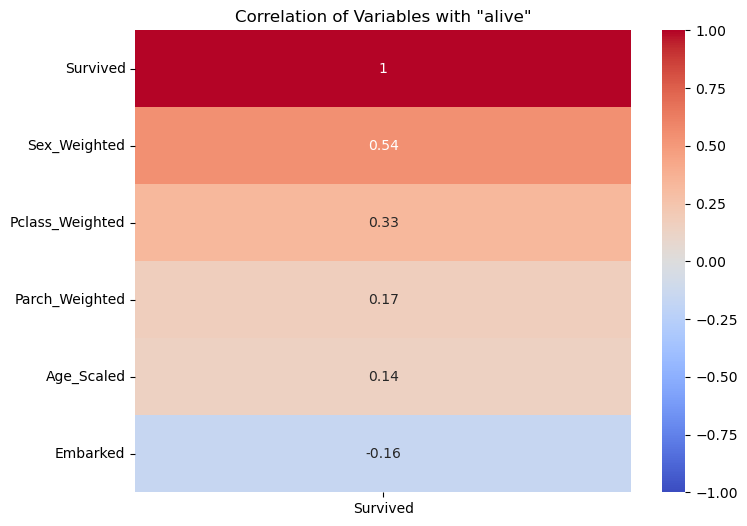

In [19]:
# Calculate the correlation matrix
corr_matrix = df_cleaned.corr()

# Filter the correlation with the 'alive' variable
corr_alive = corr_matrix[['Survived']].sort_values(by='Survived', ascending=False)

# Plot the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_alive, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Variables with "alive"')
plt.show()

In [20]:
df_cleaned.dtypes

Survived             int64
Embarked             int64
Pclass_Weighted    float64
Sex_Weighted       float64
Age_Scaled         float64
Parch_Weighted     float64
dtype: object

In [21]:
df_cleaned.head()

,Survived,Embarked,Pclass_Weighted,Sex_Weighted,Age_Scaled,Parch_Weighted
0,0,2,1.0,1.0,0.043478,1.0
1,1,0,1.5,1.5,0.025641,1.0
2,1,2,1.0,1.5,0.037037,1.0
3,1,2,1.5,1.5,0.027778,1.0
4,0,2,1.0,1.0,0.027778,1.0


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

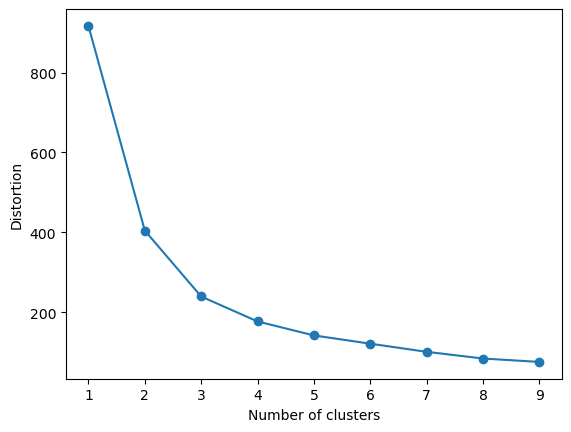

In [22]:
# Use elbow method to find the optimal number of clusters (k) for KNN imputation
def elbow_method(data, max_k = 10):
    from sklearn.cluster import KMeans
    distortions = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data.fillna(data.mean()))
        distortions.append(kmeans.inertia_)
    plt.plot(range(1, max_k), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

elbow_method(df_cleaned)

In [23]:
# Impute missing values using KNNImputer
imputer = KNNImputer(n_neighbors=3)
data_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned), columns = df_cleaned.columns)
print(data_imputed.isnull().sum())  

Survived           0
Embarked           0
Pclass_Weighted    0
Sex_Weighted       0
Age_Scaled         0
Parch_Weighted     0
dtype: int64


In [24]:
# We replace the outliers below the lower limit with the limit itself, and do the same for the upper outliers.
for col in df_cleaned.select_dtypes(include=['float', 'int']).columns:
    percentile25 = df_cleaned[col].quantile(0.25)
    percentile75 = df_cleaned[col].quantile(0.75)
    iqr = percentile75 - percentile25
    lower_bound = percentile25 - 1.5 * iqr
    upper_bound = percentile75 + 1.5 * iqr
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col]))

In [25]:
# Separate the features and labels from the imputed data
features = data_imputed.drop('Survived', axis=1) 
labels = data_imputed['Survived']

In [26]:
# Convert features and labels to PyTorch tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

In [27]:
X

tensor([[2.0000, 1.0000, 1.0000, 0.0435, 1.0000],
        [0.0000, 1.5000, 1.5000, 0.0256, 1.0000],
        [2.0000, 1.0000, 1.5000, 0.0370, 1.0000],
        ...,
        [2.0000, 1.0000, 1.5000, 0.1641, 1.5000],
        [0.0000, 1.5000, 1.0000, 0.0370, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.0303, 1.0000]])

In [28]:
y

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
      

### **MODEL CREATION AND TRAINING**

In [29]:
# Define the TitanicDataset class
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
dataset = TitanicDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [30]:
# Define the TitanicModel class
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

In [31]:
# Initialize the Titanic Model, Loss Function, and Optimizer
model = TitanicModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [33]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
train_dataset = TitanicDataset(X_train, y_train)    
val_dataset = TitanicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [34]:
# Define the model
epochs = 250
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.001)

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            predicted = (outputs >= 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        val_loss /= len(val_loader)
        accuracy = 100 * correct / total

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, '
              f'Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/250], Loss: 0.6584, Val Loss: 0.6752, Accuracy: 60.34%
Epoch [2/250], Loss: 0.6611, Val Loss: 0.6721, Accuracy: 60.34%
Epoch [3/250], Loss: 0.6644, Val Loss: 0.6673, Accuracy: 60.34%
Epoch [4/250], Loss: 0.6746, Val Loss: 0.6649, Accuracy: 60.34%
Epoch [5/250], Loss: 0.8473, Val Loss: 0.6611, Accuracy: 65.36%
Epoch [6/250], Loss: 0.5410, Val Loss: 0.6579, Accuracy: 59.22%
Epoch [7/250], Loss: 0.6239, Val Loss: 0.6553, Accuracy: 59.22%
Epoch [8/250], Loss: 0.6582, Val Loss: 0.6508, Accuracy: 59.22%
Epoch [9/250], Loss: 0.6025, Val Loss: 0.6467, Accuracy: 59.22%
Epoch [10/250], Loss: 0.6187, Val Loss: 0.6425, Accuracy: 59.22%
Epoch [11/250], Loss: 0.4391, Val Loss: 0.6400, Accuracy: 59.22%
Epoch [12/250], Loss: 0.6583, Val Loss: 0.6336, Accuracy: 62.57%
Epoch [13/250], Loss: 0.6348, Val Loss: 0.6318, Accuracy: 62.57%
Epoch [14/250], Loss: 0.6570, Val Loss: 0.6219, Accuracy: 62.57%
Epoch [15/250], Loss: 0.5517, Val Loss: 0.6156, Accuracy: 62.57%
Epoch [16/250], Loss: 0.5838, Val 

[[100   8]
 [ 23  48]]


/var/folders/1y/x8dlnnxn33ddwz4k64_z9vvc0000gn/T/ipykernel_5852/430073629.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/1y/x8dlnnxn33ddwz4k64_z9vvc0000gn/T/ipykernel_5852/430073629.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


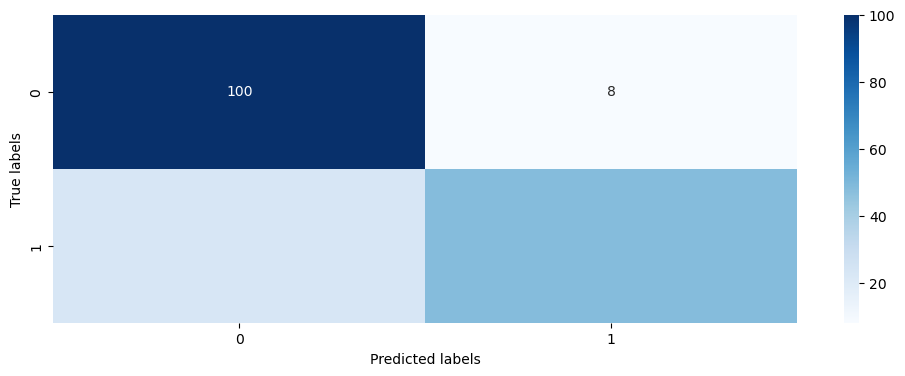

In [35]:
# Ensure that X_test and y_test are PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Move the tensors to the CPU if they are on the GPU
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

# Generate confusion matrix
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().cpu().numpy()
    y_pred = (y_pred >= 0.5).astype(int)
    y_test = y_test_tensor.cpu().numpy()
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


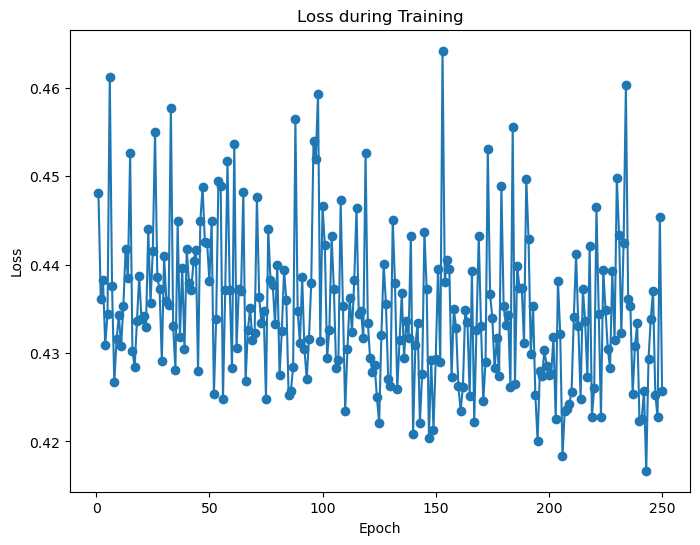

In [36]:
# Model training and visualization of the loss during training
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.show()

In [37]:
# Save the model
torch.save(model.state_dict(), 'titanic_model.pth')